In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%load_ext rpy2.ipython

# Import scripts

In [4]:
path_scripts = '/Users/simjoo/Projects/10X_aging/scripts/v3/'

In [5]:
import sys
sys.path.append(path_scripts)

In [6]:
from ipyparallel import Client
import csv
import os
import pickle
import scipy.io
import scanpy as sc
import anndata
import statsmodels.api as sm
import scanpy.external as sce
import gseapy as gp
import SEACells
import sklearn

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [7]:
%%R
#library(Seurat)
#library(SingleCellExperiment)
#library(scran)
#library(DESeq2)
#library(igraph)
#library(MAST)

NULL


In [8]:
from TenX_aging_misc_scripts_v1_0 import *
from TenX_aging_plot_v1_0 import *
from TenX_aging_mann_whitney_u_v1_0 import *

In [9]:
#exp_id = create_ID()

In [10]:
exp_id = '202111251525'
path_input = '/Users/simjoo/Projects/10X_aging/data_input/'
path_output = '/Users/simjoo/Projects/10X_aging/data_output/v3/'
path_figures = '/Users/simjoo/Projects/10X_aging/figures/v3/'

In [11]:
cmap_tab20 = {str(c) : mpl.colors.rgb2hex(plt.cm.tab20(c/20)) for c in range(20)}
cmap_tissue = {'KP':'#e31a1c', 'KPL':'#1f78b4', 'KPLR':'#ff7f00', 'KPR':'#6a3d9a', 'KPT':'#e7298a', 'healthy':'#33a02c'}
cmap_age = {'young': '#377eb8', 'aged': '#e41a1c'}
cmap_tumor_age = {'KP_young':'#fb9a99','KP_aged':'#e31a1c',
                  'KPL_young':'#a6cee3','KPL_aged':'#1f78b4',
                  'KPLR_young':'#fdbf6f','KPLR_aged':'#ff7f00',
                  'KPR_young':'#cab2d6','KPR_aged':'#6a3d9a',
                  'KPT_young':'#e78ac3','KPT_aged':'#e7298a',
                  'healthy_young':'#b2df8a','healthy_aged':'#33a02c'}
cmap_tumor_stage = {'healthy':'#33a02c',
                    '4wk':'#1f78b4',
                    '12wk':'#6a3d9a',
                    '17-18wk':'#ff7f00',
                    '19-20wk':'#e31a1c',}
cmap_epithelial_tumor = {'AT2-like': '#b2df8a',
                         'High plasticity state': '#a50f15',
                         'Hopx+ intermediate': '#fb6a4a',
                         'Ribosome high': '#c51b7d',
                         'Endoderm-like': '#542788',
                         'AT2': '#33a02c',
                         'AT1': '#e6ab02',
                         'Ciliated':'#666666'}

# Initialize engines

In [12]:
c = Client()

KeyError: 'broadcast'

In [ ]:
dview = c[:]

In [13]:
dview.execute('import sys')
dview.execute('sys.path.append("/Users/simjoo/Projects/10X_aging/scripts/v3/")')
dview.execute('from TenX_aging_misc_scripts_v1_0 import *')
dview.execute('from TenX_aging_plot_v1_0 import *')
dview.execute('from TenX_aging_mann_whitney_u_v1_0 import *')

NameError: name 'dview' is not defined

# Metacell representation of subsampled tumor data

In [12]:
X = sc.read_h5ad('%s/%s_X_LUAD_aging_pp.h5' % (path_output, exp_id))

In [13]:
Xs = sc.read_h5ad('%s/%s_Xs_LUAD_aging_KP_tumor_subsampled.h5' % (path_output, exp_id))

In [14]:
Xs.obsm['X_umap'] = Xs.obsm['X_umap_pca']

## Use highly variable features which were used as input for UMAP + PC batch correction using harmony

In [15]:
sc.tl.pca(Xs, n_comps=50)

In [16]:
sc.external.pp.harmony_integrate(Xs, 'mouse', basis='X_pca', adjusted_basis='X_pca_harmony')

2022-06-10 09:52:01,631 - harmonypy - INFO - Iteration 1 of 10
2022-06-10 09:52:27,198 - harmonypy - INFO - Iteration 2 of 10
2022-06-10 09:52:50,528 - harmonypy - INFO - Iteration 3 of 10
2022-06-10 09:53:09,647 - harmonypy - INFO - Iteration 4 of 10
2022-06-10 09:53:29,124 - harmonypy - INFO - Converged after 4 iterations


In [17]:
model = SEACells.core.SEACells(Xs, 
                               build_kernel_on='X_pca_harmony', 
                               n_SEACells=250, 
                               n_waypoint_eigs=10,
                               waypt_proportion=0.9,
                               convergence_epsilon = 1e-5)

Building kernel...
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/26588 [00:00<?, ?it/s]

Making graph symmetric...
Computing RBF kernel...


  0%|          | 0/26588 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/26588 [00:00<?, ?it/s]

Constructing CSR matrix...


In [18]:
model.initialize_archetypes()

Building kernel on X_pca_harmony
Computing diffusion components from X_pca_harmony for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 216 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/44 [00:00<?, ?it/s]

Selecting 34 cells from greedy initialization.


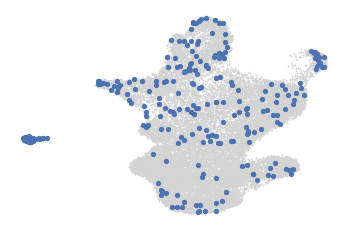

In [19]:
SEACells.plot.plot_initialization(Xs, model)

In [20]:
model.fit(n_iter=20)

Randomly initialized A matrix.
Setting convergence threshold at 0.0229159568053421
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 20 iterations.


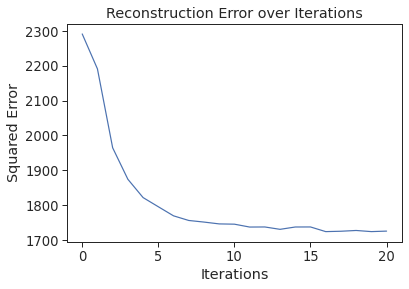

In [21]:
model.plot_convergence()

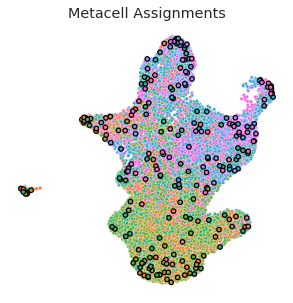

In [22]:
SEACells.plot.plot_2D(Xs, key='X_umap', colour_metacells=True)

/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


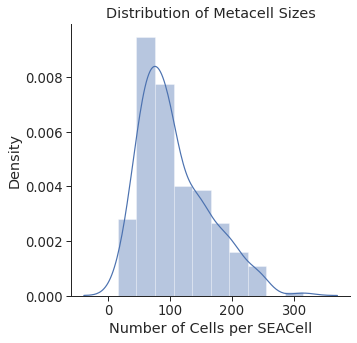

size
SEACell                  
AAACCCAAGATTAGTG-14    75
AAAGGATAGAGCCGTA-5    113
AAAGGATTCAATCTCT-5    195
AAAGGTACACAGCATT-12    82
AACAAAGCATGAAAGT-9    147
...                   ...
TTTAGTCTCTCGACCT-5    130
TTTATGCGTGTCCAAT-14   151
TTTATGCTCTAGAGTC-0     60
TTTGGAGCATGTGACT-12    62
TTTGGTTTCTTGCAAG-5    191

[250 rows x 1 columns]

In [23]:
SEACells.plot.plot_SEACell_sizes(Xs, bins=10)

In [24]:
import seaborn as sns

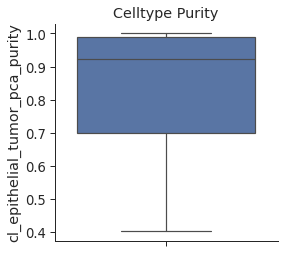

cl_epithelial_tumor_pca  \
SEACell                                           
AAACCCAAGATTAGTG-14                    AT1-like   
AAAGGATAGAGCCGTA-5                     AT2-like   
AAAGGATTCAATCTCT-5                     AT2-like   
AAAGGTACACAGCATT-12  High plasticity cell state   
AACAAAGCATGAAAGT-9                     AT2-like   

                     cl_epithelial_tumor_pca_purity  
SEACell                                              
AAACCCAAGATTAGTG-14                        0.786667  
AAAGGATAGAGCCGTA-5                         0.743363  
AAAGGATTCAATCTCT-5                         0.558974  
AAAGGTACACAGCATT-12                        1.000000  
AACAAAGCATGAAAGT-9                         0.972789

In [25]:
SEACell_purity = SEACells.evaluate.compute_celltype_purity(Xs, 'cl_epithelial_tumor_pca')

plt.figure(figsize=(4,4))
sns.boxplot(data=SEACell_purity, y='cl_epithelial_tumor_pca_purity')
plt.title('Celltype Purity')
sns.despine()
plt.show()
plt.close()

SEACell_purity.head()

# Visualize metacells

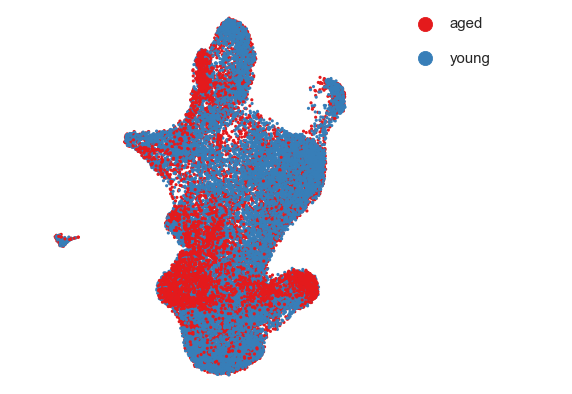

In [26]:
draw_scatter_groups(Xs.obsm['X_umap_pca'], 
                    Xs.obs['age'],
                    cmap_age,
                    s=10, show_axes = False)

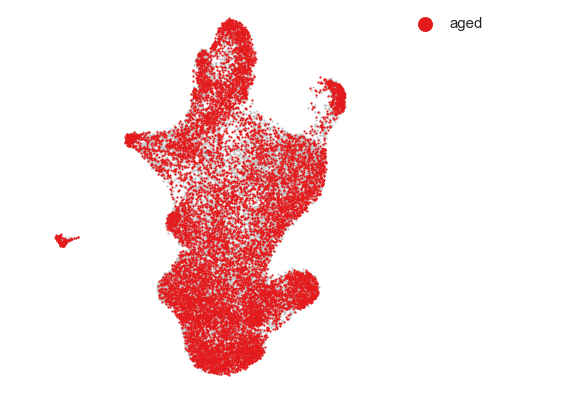

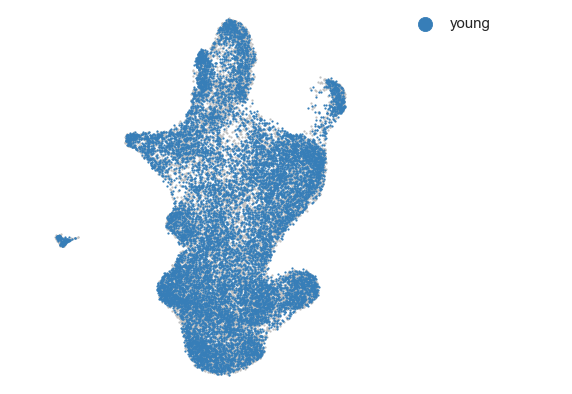

In [157]:
draw_scatter_groups_individual(Xs.obsm['X_umap_pca'], 
                    Xs.obs['age'],
                    cmap=cmap_age,
                    s=5, show_axes = False)

## Visualize metacells - percentage of young and aged cells

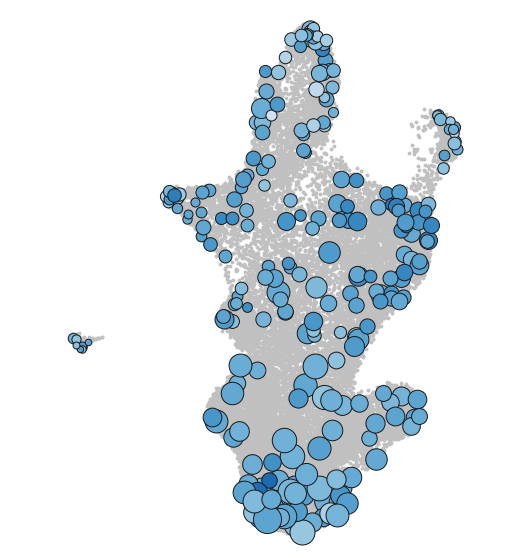

In [27]:
umap = pd.DataFrame(Xs.obsm['X_umap']).set_index(Xs.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = mpl.colors.rgb2hex(plt.cm.Blues(Counter(Xs.obs['age'].loc[ass_tmp])['young'] / len(ass_tmp))))

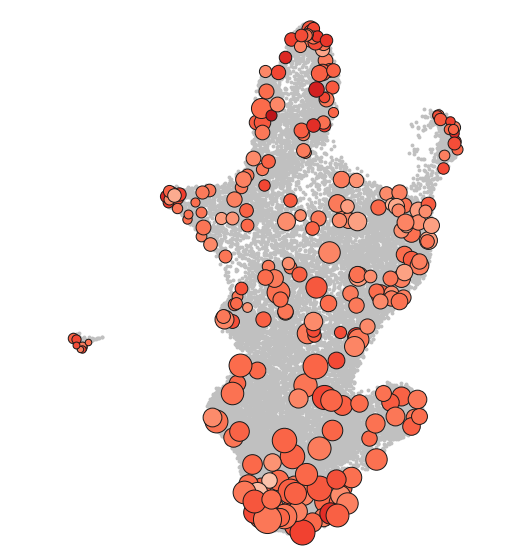

In [28]:
umap = pd.DataFrame(Xs.obsm['X_umap']).set_index(Xs.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = mpl.colors.rgb2hex(plt.cm.Reds(Counter(Xs.obs['age'].loc[ass_tmp])['aged'] / len(ass_tmp))))

## Visualize metacells - ratio of young and aged cells

/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_82325/3662130869.py:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


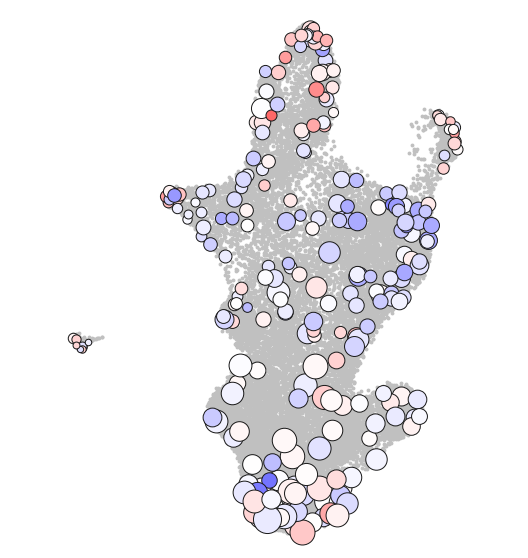

In [140]:
umap = pd.DataFrame(Xs.obsm['X_umap']).set_index(Xs.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = mpl.colors.rgb2hex(plt.cm.bwr(Counter(Xs.obs['age'].loc[ass_tmp])['aged'] / len(ass_tmp))))
    
figname = 'umap_LUAD_mcs_age.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Most common cell population

In [30]:
cmap_epithelial_tumor = {'AT2-like': '#b2df8a',
                         'AT2': '#33a02c',
                         'High plasticity cell state': '#a50f15',
                         'AT1-like': '#fb6a4a',
                         'Ribosome high': '#c51b7d',
                         'Endoderm-like': '#542788',
                         'AT1': '#e6ab02',
                         'Ciliated':'#666666', 
                         'Other':'silver'}

/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_82325/3649807869.py:62: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


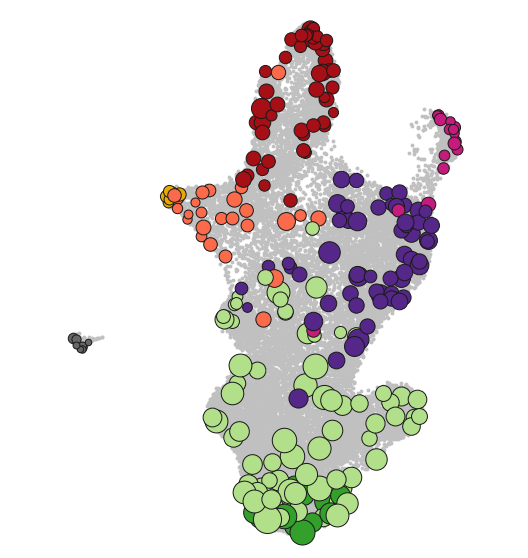

In [139]:
umap = pd.DataFrame(Xs.obsm['X_umap']).set_index(Xs.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    cnts_tmp = Counter(Xs.obs['cl_epithelial_tumor_pca'].loc[ass_tmp])
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = cmap_epithelial_tumor[max(cnts_tmp, key=cnts_tmp.get)])
    
figname = 'umap_LUAD_mcs_pop.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Metacell representation of subsampled tumor data - healthy

In [141]:
X = sc.read_h5ad('%s/%s_X_LUAD_aging_pp.h5' % (path_output, exp_id))

In [142]:
Xs = sc.read_h5ad('%s/%s_Xs_LUAD_aging_KP_tumor_subsampled.h5' % (path_output, exp_id))
Xs_ = sc.read_h5ad('%s/%s_Xs_LUAD_aging_KP_tumor_subsampled.h5' % (path_output, exp_id))

In [143]:
Xs.obsm['X_umap'] = Xs.obsm['X_umap_pca']

## Select healthy cells

In [144]:
c_sel = Xs.obs[Xs.obs['tumor_stage']=='healthy'].index

In [145]:
len(c_sel)

4083

In [146]:
Xs = Xs[c_sel]

## Use highly variable features which were used as input for UMAP + PC batch correction using harmony

In [147]:
sc.tl.pca(Xs, n_comps=50)

In [148]:
sc.external.pp.harmony_integrate(Xs, 'mouse', basis='X_pca', adjusted_basis='X_pca_harmony')

2022-08-12 14:06:33,550 - harmonypy - INFO - Iteration 1 of 10
2022-08-12 14:06:35,158 - harmonypy - INFO - Iteration 2 of 10
2022-08-12 14:06:36,890 - harmonypy - INFO - Iteration 3 of 10
2022-08-12 14:06:38,693 - harmonypy - INFO - Iteration 4 of 10
2022-08-12 14:06:41,193 - harmonypy - INFO - Iteration 5 of 10
2022-08-12 14:06:42,885 - harmonypy - INFO - Converged after 5 iterations


In [149]:
model = SEACells.core.SEACells(Xs, 
                               build_kernel_on='X_pca_harmony', 
                               n_SEACells=40, 
                               n_waypoint_eigs=10,
                               waypt_proportion=0.9,
                               convergence_epsilon = 1e-5)

Building kernel...
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/4083 [00:00<?, ?it/s]

Making graph symmetric...
Computing RBF kernel...


  0%|          | 0/4083 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/4083 [00:00<?, ?it/s]

Constructing CSR matrix...


In [150]:
model.initialize_archetypes()

Building kernel on X_pca_harmony
Computing diffusion components from X_pca_harmony for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 30 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/20 [00:00<?, ?it/s]

Selecting 10 cells from greedy initialization.


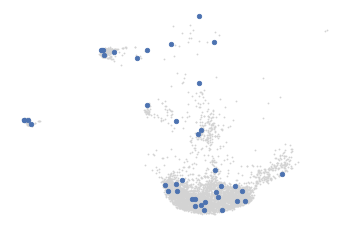

In [151]:
SEACells.plot.plot_initialization(Xs, model)

In [152]:
model.fit(n_iter=20)

Randomly initialized A matrix.
Setting convergence threshold at 0.009087444522674827
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 20 iterations.


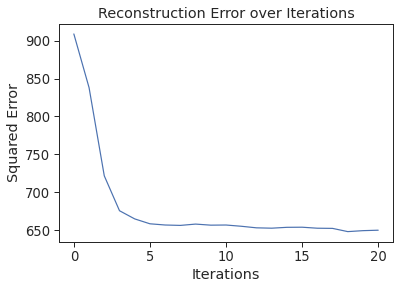

In [153]:
model.plot_convergence()

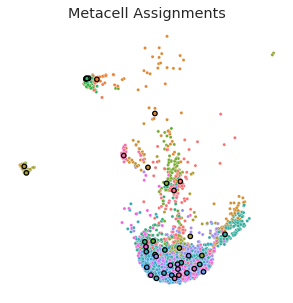

In [154]:
SEACells.plot.plot_2D(Xs, key='X_umap', colour_metacells=True)

/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


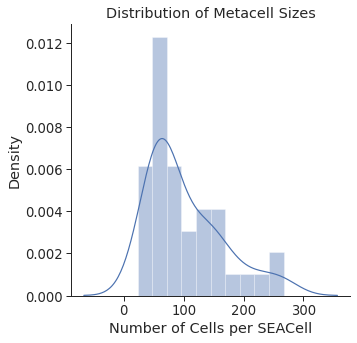

size
SEACell                 
AACAAAGCAGCTCCTT-4    45
AAGACAATCATTACGG-5   259
AATAGAGTCGCGCTGA-5   212
ACATGGTTCGACAGCC-1    62
ACCACAAGTGTTCCAA-5   127
ACGGGTCGTGGCGAAT-2    65
ACTTACTCATGGTCTA-0    57
AGATCCAGTTTCGCTC-5   155
AGGAGGTCATGCCGAC-5   139
AGTCAACTCTTCGCTG-5    66
ATAACGCAGAAGGGTA-2    41
ATCAGGTGTCAGATTC-4   128
ATCCATTCATATACCG-5    40
ATCCGAACAGCCTATA-2    23
CACGTTCGTTCCTAGA-4    93
CCGATGGGTAGGGTAC-4    76
CCGTAGGAGCTATCCA-5    73
CCGTGGATCTATCCCG-0    55
CCTCTAGCAGCAGATG-4   226
CGCATAATCGGCGATC-5    66
CGTTCTGAGTATCTGC-5   162
CTTTGCGAGTATCGAA-2    38
GACACGCCAGAGACTG-5   120
GATAGAAGTCCTGTTC-5   267
GCAATCAAGGCGCTCT-2    69
GCCTGTTCATGGGATG-5    75
GGACATTGTAACGTTC-3    63
GGAGAACGTGTGTGGA-5    50
GGAGCAACAGTCAGAG-5   108
GGGAGATGTTCGTTGA-0    59
GTCCTCACAGAGATTA-5   147
TACCCACAGGGACAGG-5   107
TACCTCGGTGATTCTG-4    67
TCACATTTCAGACCTA-4   168
TGGGCTGCAAGTCCAT-5   184
TTCAATCAGGTAGACC-4    43
TTGAACGCACCTGGTG-0    74
TTGATGGAGGAGAGGC-4    78
TTTAGTCTCTCGACCT-5   142
TTTGGTTAGTTGCAGG-2    54

In [155]:
SEACells.plot.plot_SEACell_sizes(Xs, bins=10)

In [156]:
import seaborn as sns

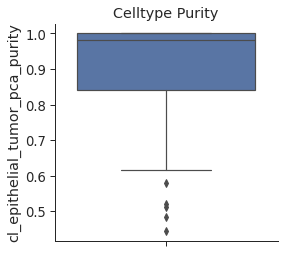

cl_epithelial_tumor_pca  cl_epithelial_tumor_pca_purity
SEACell                                                                       
AACAAAGCAGCTCCTT-4  High plasticity cell state                        0.444444
AAGACAATCATTACGG-5                         AT2                        0.969112
AATAGAGTCGCGCTGA-5                         AT2                        1.000000
ACATGGTTCGACAGCC-1                    Ciliated                        0.983871
ACCACAAGTGTTCCAA-5                         AT2                        1.000000

In [157]:
SEACell_purity = SEACells.evaluate.compute_celltype_purity(Xs, 'cl_epithelial_tumor_pca')

plt.figure(figsize=(4,4))
sns.boxplot(data=SEACell_purity, y='cl_epithelial_tumor_pca_purity')
plt.title('Celltype Purity')
sns.despine()
plt.show()
plt.close()

SEACell_purity.head()

# Visualize metacells

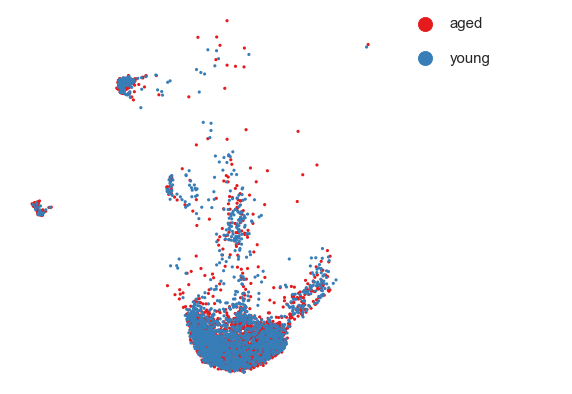

In [158]:
draw_scatter_groups(Xs.obsm['X_umap_pca'], 
                    Xs.obs['age'],
                    cmap_age,
                    s=10, show_axes = False)

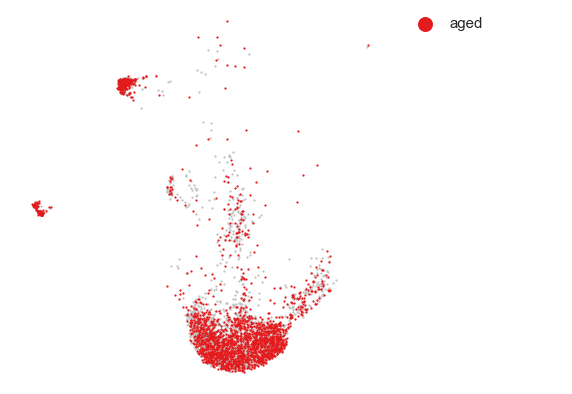

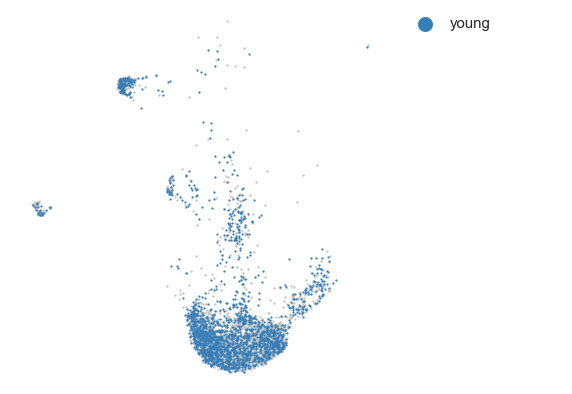

In [159]:
draw_scatter_groups_individual(Xs.obsm['X_umap_pca'], 
                    Xs.obs['age'],
                    cmap=cmap_age,
                    s=5, show_axes = False)

## Visualize metacells - percentage of young and aged cells

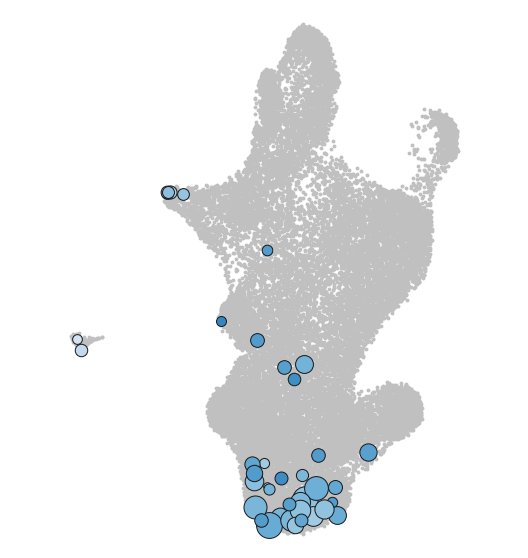

In [160]:
umap = pd.DataFrame(Xs_.obsm['X_umap_pca']).set_index(Xs_.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = mpl.colors.rgb2hex(plt.cm.Blues(Counter(Xs.obs['age'].loc[ass_tmp])['young'] / len(ass_tmp))))

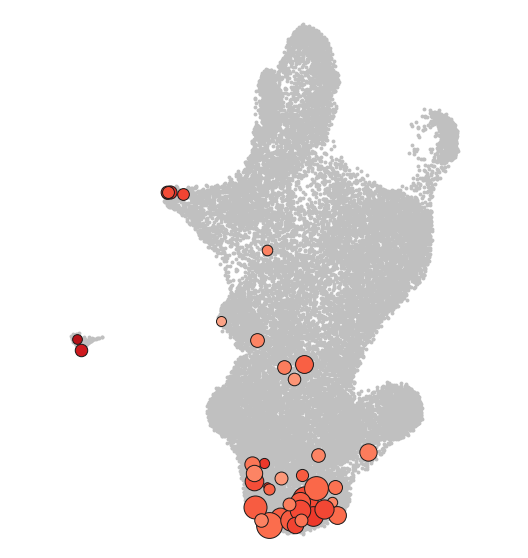

In [161]:
umap = pd.DataFrame(Xs_.obsm['X_umap_pca']).set_index(Xs_.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = mpl.colors.rgb2hex(plt.cm.Reds(Counter(Xs.obs['age'].loc[ass_tmp])['aged'] / len(ass_tmp))))

## Visualize metacells - ratio of young and aged cells

/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_82325/764843230.py:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


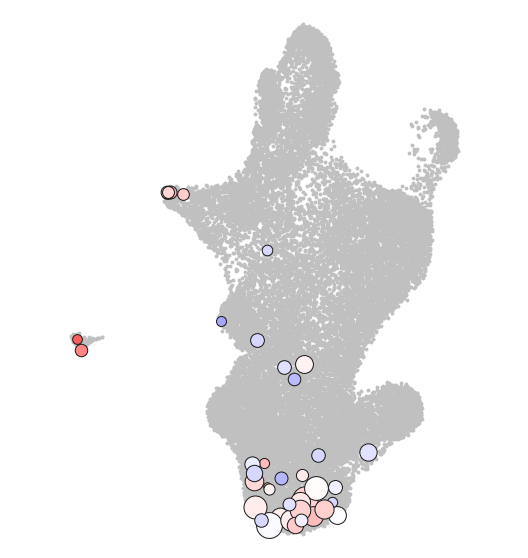

In [162]:
umap = pd.DataFrame(Xs_.obsm['X_umap_pca']).set_index(Xs_.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = mpl.colors.rgb2hex(plt.cm.bwr(Counter(Xs.obs['age'].loc[ass_tmp])['aged'] / len(ass_tmp))))
    
figname = 'umap_LUAD_mcs_age_healthy.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Most common cell population

In [163]:
cmap_epithelial_tumor = {'AT2-like': '#b2df8a',
                         'AT2': '#33a02c',
                         'High plasticity cell state': '#a50f15',
                         'AT1-like': '#fb6a4a',
                         'Ribosome high': '#c51b7d',
                         'Endoderm-like': '#542788',
                         'AT1': '#e6ab02',
                         'Ciliated':'#666666', 
                         'Other':'silver'}

/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_82325/54883078.py:63: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


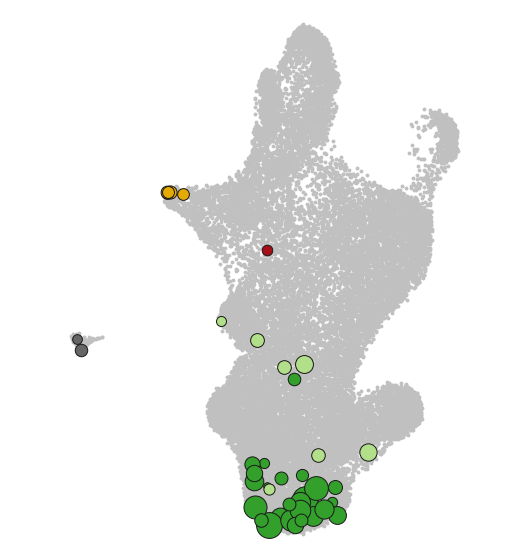

In [164]:
umap = pd.DataFrame(Xs_.obsm['X_umap_pca']).set_index(Xs_.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    cnts_tmp = Counter(Xs.obs['cl_epithelial_tumor_pca'].loc[ass_tmp])
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = cmap_epithelial_tumor[max(cnts_tmp, key=cnts_tmp.get)])
    
    
figname = 'umap_LUAD_mcs_pop_healthy.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Checkpoint

In [165]:
Xs.write_h5ad('%s/%s_Xs_LUAD_aging_KP_tumor_subsampled_metacells_healthy.h5' % (path_output, exp_id))

# Metacell representation of subsampled tumor data - 4wk

In [166]:
X = sc.read_h5ad('%s/%s_X_LUAD_aging_pp.h5' % (path_output, exp_id))

In [167]:
Xs = sc.read_h5ad('%s/%s_Xs_LUAD_aging_KP_tumor_subsampled.h5' % (path_output, exp_id))
Xs_ = sc.read_h5ad('%s/%s_Xs_LUAD_aging_KP_tumor_subsampled.h5' % (path_output, exp_id))

In [168]:
Xs.obsm['X_umap'] = Xs.obsm['X_umap_pca']

## Select healthy cells

In [169]:
c_sel = Xs.obs[Xs.obs['tumor_stage']=='4wk'].index

In [170]:
len(c_sel)

5535

In [171]:
Xs = Xs[c_sel]

## Use highly variable features which were used as input for UMAP + PC batch correction using harmony

In [172]:
sc.tl.pca(Xs, n_comps=50)

In [173]:
sc.external.pp.harmony_integrate(Xs, 'mouse', basis='X_pca', adjusted_basis='X_pca_harmony')

2022-08-12 14:10:27,509 - harmonypy - INFO - Iteration 1 of 10
2022-08-12 14:10:30,496 - harmonypy - INFO - Iteration 2 of 10
2022-08-12 14:10:33,571 - harmonypy - INFO - Iteration 3 of 10
2022-08-12 14:10:35,935 - harmonypy - INFO - Iteration 4 of 10
2022-08-12 14:10:37,403 - harmonypy - INFO - Iteration 5 of 10
2022-08-12 14:10:38,705 - harmonypy - INFO - Iteration 6 of 10
2022-08-12 14:10:39,787 - harmonypy - INFO - Iteration 7 of 10
2022-08-12 14:10:40,713 - harmonypy - INFO - Iteration 8 of 10
2022-08-12 14:10:42,013 - harmonypy - INFO - Iteration 9 of 10
2022-08-12 14:10:43,031 - harmonypy - INFO - Converged after 9 iterations


In [174]:
model = SEACells.core.SEACells(Xs, 
                               build_kernel_on='X_pca_harmony', 
                               n_SEACells=55, 
                               n_waypoint_eigs=10,
                               waypt_proportion=0.9,
                               convergence_epsilon = 1e-5)

Building kernel...
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/5535 [00:00<?, ?it/s]

Making graph symmetric...
Computing RBF kernel...


  0%|          | 0/5535 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/5535 [00:00<?, ?it/s]

Constructing CSR matrix...


In [175]:
model.initialize_archetypes()

Building kernel on X_pca_harmony
Computing diffusion components from X_pca_harmony for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 45 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/20 [00:00<?, ?it/s]

Selecting 10 cells from greedy initialization.


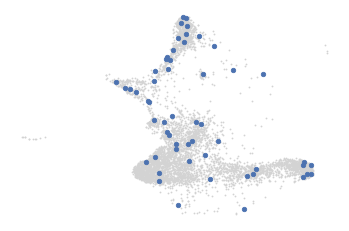

In [176]:
SEACells.plot.plot_initialization(Xs, model)

In [177]:
model.fit(n_iter=20)

Randomly initialized A matrix.
Setting convergence threshold at 0.01047256129277323
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 20 iterations.


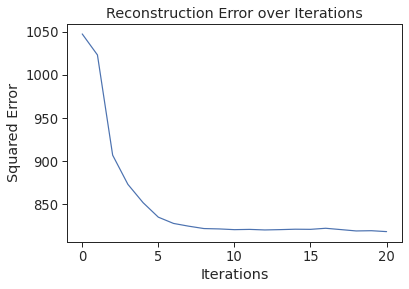

In [178]:
model.plot_convergence()

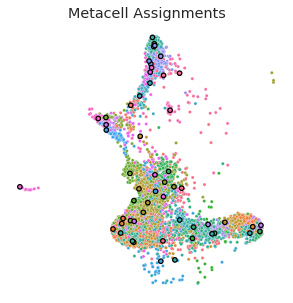

In [179]:
SEACells.plot.plot_2D(Xs, key='X_umap', colour_metacells=True)

/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


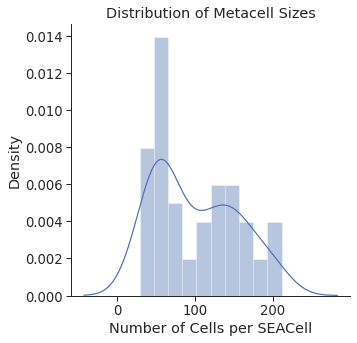

size
SEACell                 
ACCAAACTCGTCTCAC-6    55
ACCTGAAGTGGGCTTC-6    50
ACTCCCAGTTTAGACC-6   148
ACTTAGGTCGACGCGT-6   112
AGAAGCGCATTAGGCT-6   198
AGACAGGTCGGAGCAA-6   127
AGCTTCCAGCAAGCCA-6    54
AGGTTGTCAGAAATTG-6    68
ATCGCCTAGGAGGCAG-6   181
ATCGTGACAGGCGATA-6    52
ATTGTTCCAAGCCTGC-6   211
CACGGGTAGTTTAGGA-6   185
CACTAAGTCTGTGCTC-6   105
CACTGAATCCCTGTTG-6    56
CATACAGCAGACCAGA-6   108
CATAGACGTAGTACGG-6    56
CATTGTTTCGGTCATA-6   149
CCAATTTGTCACGACC-6   131
CCCTAACTCATTGGTG-6    56
CCGTAGGAGTAAACGT-6   200
CGCATGGCAGTAGTGG-6   114
CGGAATTTCGCCTATC-6    29
CGGTCAGTCAGCTAGT-6   154
CTACCCAGTTAAGAAC-6    57
CTGGACGCACAGGATG-6    83
CTTGAGAGTCAAGGCA-6    58
GACTCTCCACTGGAAG-6    77
GCATCGGGTTGTTTGG-6   162
GGCAGTCAGGCCTTCG-6   167
GGCTTTCAGATGGTCG-6    33
GGTGTCGAGATGCTTC-6    47
GTACAACAGCCACTCG-6   126
GTACAACGTTGCATGT-6   163
GTAGGAGCACTGTCCT-6   149
GTGCTGGTCATTCACT-6    30
GTTACAGAGCTGGTGA-6    46
GTTGCGGTCACTGAAC-6    54
TAAGCCATCGATGCTA-6    33
TACTTGTTCTTTCGAT-6    74
TATTCCACAGGTGACA-6   159
TCAATTCTCTTACGGA-6    30
TCACAAGCATCTGTTT-6    65
TCAGGGCCAATTAGGA-6   120
TCATGCCCACAATGTC-6    93
TCATTGTTCGCCGATG-6   145
TCTACATAGACAGCGT-6    89
TGAATCGTCCGATAGT-6   195
TGCCGAGTCAAGAAAC-6    69
TGGTACAGTAACGCGA-6    42
TTAGGGTAGACATAAC-6    51
TTAGGGTAGTCATTGC-6   122
TTGACCCAGTCCTGCG-6   136
TTGGGTACACATGACT-6    60
TTTATGCGTAACACCT-6    62
TTTCGATCACTAGAGG-6   139

In [180]:
SEACells.plot.plot_SEACell_sizes(Xs, bins=10)

In [181]:
import seaborn as sns

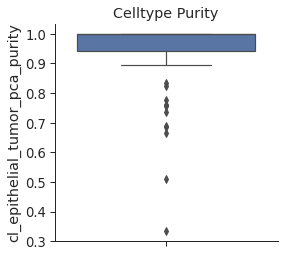

cl_epithelial_tumor_pca  cl_epithelial_tumor_pca_purity
SEACell                                                                   
ACCAAACTCGTCTCAC-6                     AT2                        0.509091
ACCTGAAGTGGGCTTC-6                AT1-like                        0.940000
ACTCCCAGTTTAGACC-6                AT2-like                        1.000000
ACTTAGGTCGACGCGT-6                AT2-like                        1.000000
AGAAGCGCATTAGGCT-6                AT2-like                        1.000000

In [182]:
SEACell_purity = SEACells.evaluate.compute_celltype_purity(Xs, 'cl_epithelial_tumor_pca')

plt.figure(figsize=(4,4))
sns.boxplot(data=SEACell_purity, y='cl_epithelial_tumor_pca_purity')
plt.title('Celltype Purity')
sns.despine()
plt.show()
plt.close()

SEACell_purity.head()

# Visualize metacells

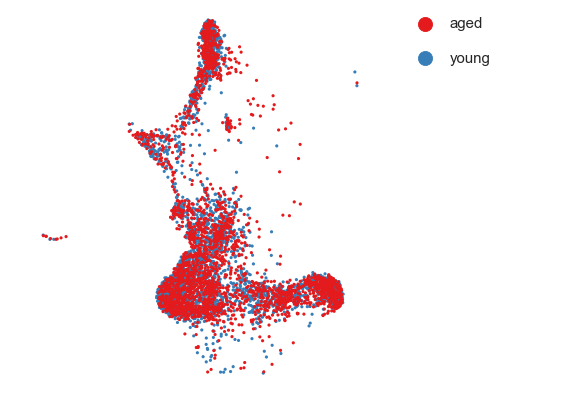

In [183]:
draw_scatter_groups(Xs.obsm['X_umap_pca'], 
                    Xs.obs['age'],
                    cmap_age,
                    s=10, show_axes = False)

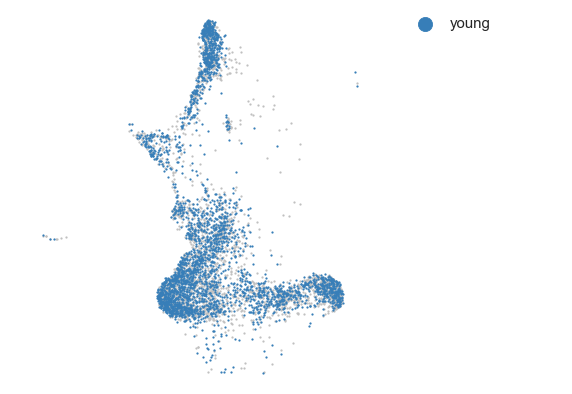

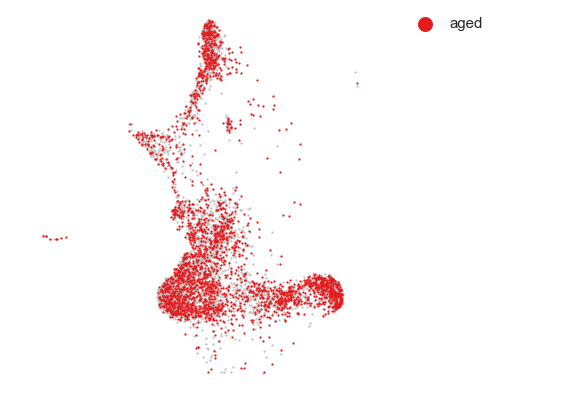

In [184]:
draw_scatter_groups_individual(Xs.obsm['X_umap_pca'], 
                    Xs.obs['age'],
                    cmap=cmap_age,
                    s=5, show_axes = False)

## Visualize metacells - percentage of young and aged cells

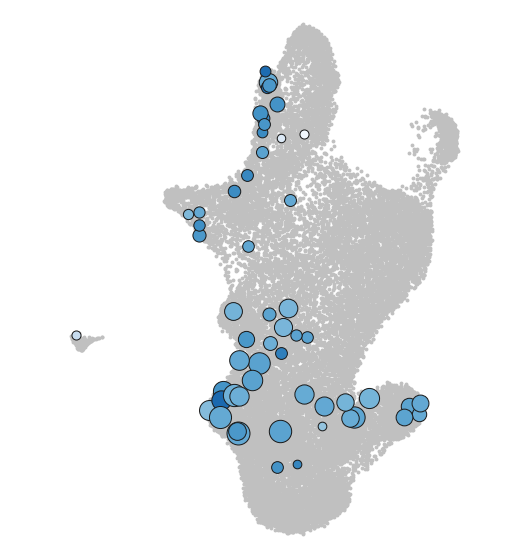

In [185]:
umap = pd.DataFrame(Xs_.obsm['X_umap_pca']).set_index(Xs_.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = mpl.colors.rgb2hex(plt.cm.Blues(Counter(Xs.obs['age'].loc[ass_tmp])['young'] / len(ass_tmp))))

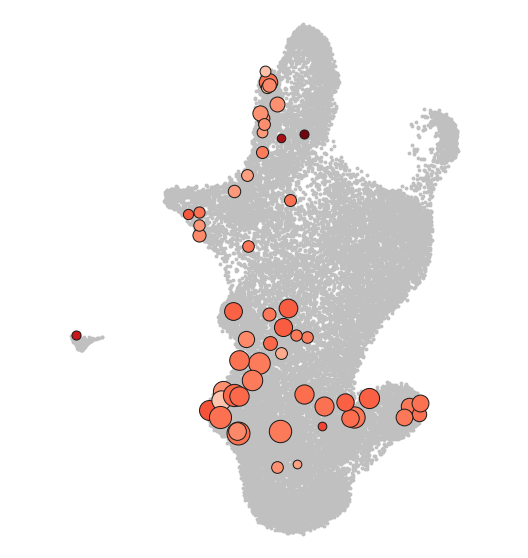

In [186]:
umap = pd.DataFrame(Xs_.obsm['X_umap_pca']).set_index(Xs_.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = mpl.colors.rgb2hex(plt.cm.Reds(Counter(Xs.obs['age'].loc[ass_tmp])['aged'] / len(ass_tmp))))

## Visualize metacells - ratio of young and aged cells

/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_82325/2112351212.py:62: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


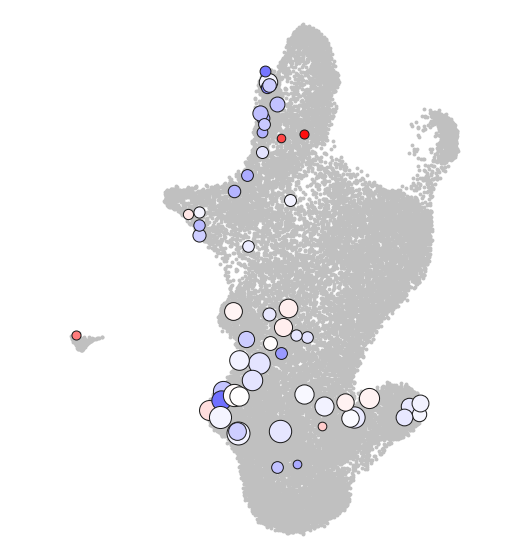

In [187]:
umap = pd.DataFrame(Xs_.obsm['X_umap_pca']).set_index(Xs_.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = mpl.colors.rgb2hex(plt.cm.bwr(Counter(Xs.obs['age'].loc[ass_tmp])['aged'] / len(ass_tmp))))
    
    
figname = 'umap_LUAD_mcs_age_4wk.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Most common cell population

In [188]:
cmap_epithelial_tumor = {'AT2-like': '#b2df8a',
                         'AT2': '#33a02c',
                         'High plasticity cell state': '#a50f15',
                         'AT1-like': '#fb6a4a',
                         'Ribosome high': '#c51b7d',
                         'Endoderm-like': '#542788',
                         'AT1': '#e6ab02',
                         'Ciliated':'#666666', 
                         'Other':'silver'}

/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_82325/292344606.py:63: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


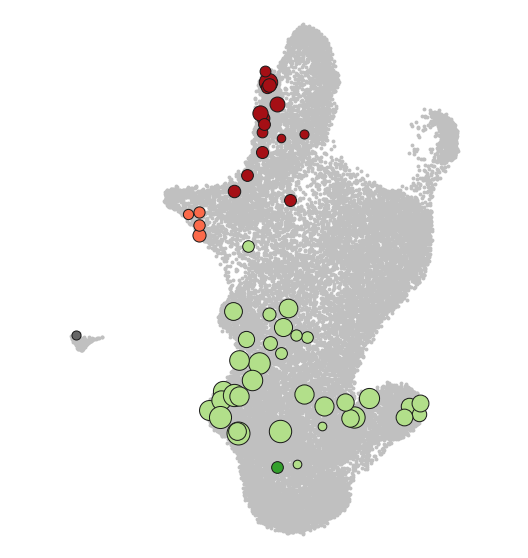

In [189]:
umap = pd.DataFrame(Xs_.obsm['X_umap_pca']).set_index(Xs_.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    cnts_tmp = Counter(Xs.obs['cl_epithelial_tumor_pca'].loc[ass_tmp])
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = cmap_epithelial_tumor[max(cnts_tmp, key=cnts_tmp.get)])
    
    
figname = 'umap_LUAD_mcs_pop_4wk.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Checkpoint

In [190]:
Xs.write_h5ad('%s/%s_Xs_LUAD_aging_KP_tumor_subsampled_metacells_4wk.h5' % (path_output, exp_id))

# Metacell representation of subsampled tumor data - 12wk

In [191]:
X = sc.read_h5ad('%s/%s_X_LUAD_aging_pp.h5' % (path_output, exp_id))

In [192]:
Xs = sc.read_h5ad('%s/%s_Xs_LUAD_aging_KP_tumor_subsampled.h5' % (path_output, exp_id))
Xs_ = sc.read_h5ad('%s/%s_Xs_LUAD_aging_KP_tumor_subsampled.h5' % (path_output, exp_id))

In [193]:
Xs.obsm['X_umap'] = Xs.obsm['X_umap_pca']

## Select healthy cells

In [194]:
c_sel = Xs.obs[Xs.obs['tumor_stage']=='12wk'].index

In [195]:
len(c_sel)

6000

In [196]:
Xs = Xs[c_sel]

## Use highly variable features which were used as input for UMAP + PC batch correction using harmony

In [197]:
sc.tl.pca(Xs, n_comps=50)

In [198]:
sc.external.pp.harmony_integrate(Xs, 'mouse', basis='X_pca', adjusted_basis='X_pca_harmony')

2022-08-12 14:14:59,039 - harmonypy - INFO - Iteration 1 of 10
2022-08-12 14:15:02,831 - harmonypy - INFO - Iteration 2 of 10
2022-08-12 14:15:05,858 - harmonypy - INFO - Iteration 3 of 10
2022-08-12 14:15:08,898 - harmonypy - INFO - Iteration 4 of 10
2022-08-12 14:15:11,735 - harmonypy - INFO - Iteration 5 of 10
2022-08-12 14:15:13,623 - harmonypy - INFO - Iteration 6 of 10
2022-08-12 14:15:14,673 - harmonypy - INFO - Iteration 7 of 10
2022-08-12 14:15:16,798 - harmonypy - INFO - Iteration 8 of 10
2022-08-12 14:15:19,813 - harmonypy - INFO - Iteration 9 of 10
2022-08-12 14:15:21,447 - harmonypy - INFO - Iteration 10 of 10
2022-08-12 14:15:22,440 - harmonypy - INFO - Stopped before convergence


In [199]:
model = SEACells.core.SEACells(Xs, 
                               build_kernel_on='X_pca_harmony', 
                               n_SEACells=60, 
                               n_waypoint_eigs=10,
                               waypt_proportion=0.9,
                               convergence_epsilon = 1e-5)

Building kernel...
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/6000 [00:00<?, ?it/s]

Making graph symmetric...
Computing RBF kernel...


  0%|          | 0/6000 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/6000 [00:00<?, ?it/s]

Constructing CSR matrix...


In [200]:
model.initialize_archetypes()

Building kernel on X_pca_harmony
Computing diffusion components from X_pca_harmony for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 45 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/25 [00:00<?, ?it/s]

Selecting 15 cells from greedy initialization.


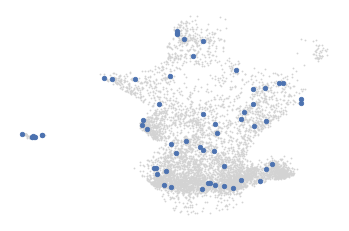

In [201]:
SEACells.plot.plot_initialization(Xs, model)

In [202]:
model.fit(n_iter=20)

Randomly initialized A matrix.
Setting convergence threshold at 0.010610359170571747
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 20 iterations.


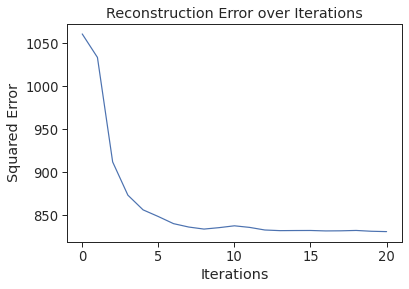

In [203]:
model.plot_convergence()

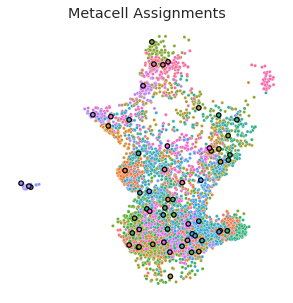

In [204]:
SEACells.plot.plot_2D(Xs, key='X_umap', colour_metacells=True)

/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


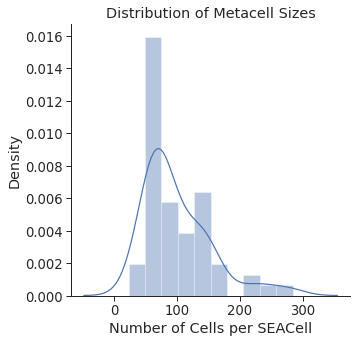

size
SEACell                 
AAAGTCCCACTGTCGG-7    55
AACAAAGCATGAAAGT-9   284
AACCATGGTTACGCCG-7    54
AAGCGAGGTGTCCGGT-7    50
AATCACGCAGTTGTTG-8   145
AATGGAATCTTTCCGG-8    73
ACAGAAAGTCCTACAA-9    70
ACATCCCAGGCGTCCT-7    58
ACGTCCTCAGTCAGTT-9    71
AGATGCTAGCGTGAAC-8   110
AGCCACGAGCGCTGAA-7    72
AGCTCAATCTGCTGAA-7    46
AGGAATAAGGTGGTTG-8    23
AGGTGTTTCTACAGGT-8   228
AGTACCACAGGCACTC-7    67
ATACCGAAGTACGAGC-8   160
ATACCGACACTCACTC-9    85
ATACCGATCACTTATC-7    76
ATCCTATAGGGCGAGA-8    51
ATTACTCTCATCCTAT-8    95
CAAGACTGTCACTTCC-8    73
CAAGCTACACATAACC-7   124
CAGGGCTCACGATTCA-8   109
CATGAGTCAGTCGCTG-7    38
CATTCTAAGACTGTTC-7    74
CCGTGAGTCGAGTCTA-8    57
CCTCACATCAAGAAAC-8   132
CGTAGTAGTAGGTGCA-9    91
CTACCCACACCTGCAG-7   103
CTCAACCAGGCATGCA-7    65
CTCAATTGTCTCCCTA-8   129
CTCATGCAGAGTAACT-9   257
CTTCTCTTCATCGCTC-7    75
GACACGCTCGTCTACC-9   179
GAGACCCCAGGCATTT-7    51
GATCCCTTCCAACCGG-9   133
GCAGTTAAGACCTCCG-7    87
GGGACCTTCTCTTGCG-9    55
GGTTAACAGCTTTCTT-7    82
GTACAACGTACCTGTA-7   218
GTCTGTCAGTTGGCGA-7    50
GTGCACGAGTGCAAAT-7    69
GTTACAGCAATCCAGT-8    91
TAGACTGTCCTGATAG-7    62
TATTCCATCCGCACTT-7   104
TCATTACTCGGTCGAC-9   157
TCCGAAATCTTGGTGA-9   140
TCCGGGACACTTGTGA-7   137
TCCTAATGTCTACAAC-7    65
TCTACATGTTGGAGAC-8    60
TGAATCGCAGCAAGAC-9    87
TGAGCATTCATTGCGA-7   110
TGCGACGGTTGACTGT-8   135
TGGATCACAACCCGCA-8    70
TGTGATGTCTAGCCAA-8   144
TGTTCATGTTATCTGG-9   152
TTACAGGAGATCGCTT-7    51
TTCTAGTAGATGTAGT-7    87
TTCTCTCTCCTGATAG-8   153
TTTCAGTTCCTTGAAG-7    71

In [205]:
SEACells.plot.plot_SEACell_sizes(Xs, bins=10)

In [206]:
import seaborn as sns

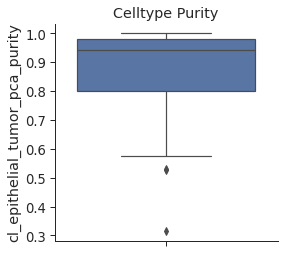

cl_epithelial_tumor_pca  cl_epithelial_tumor_pca_purity
SEACell                                                                   
AAAGTCCCACTGTCGG-7           Endoderm-like                        0.981818
AACAAAGCATGAAAGT-9                AT2-like                        0.996479
AACCATGGTTACGCCG-7                AT1-like                        0.314815
AAGCGAGGTGTCCGGT-7           Endoderm-like                        0.680000
AATCACGCAGTTGTTG-8                AT2-like                        0.931034

In [207]:
SEACell_purity = SEACells.evaluate.compute_celltype_purity(Xs, 'cl_epithelial_tumor_pca')

plt.figure(figsize=(4,4))
sns.boxplot(data=SEACell_purity, y='cl_epithelial_tumor_pca_purity')
plt.title('Celltype Purity')
sns.despine()
plt.show()
plt.close()

SEACell_purity.head()

# Visualize metacells

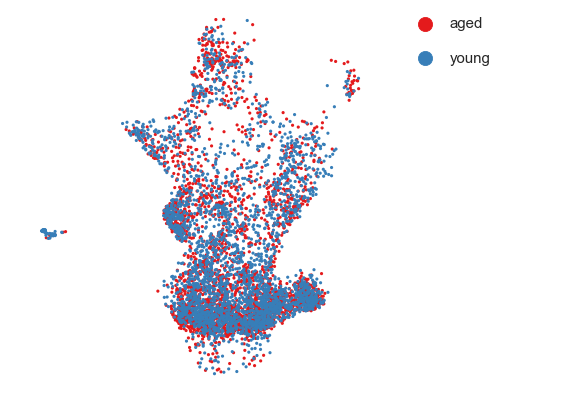

In [208]:
draw_scatter_groups(Xs.obsm['X_umap_pca'], 
                    Xs.obs['age'],
                    cmap_age,
                    s=10, show_axes = False)

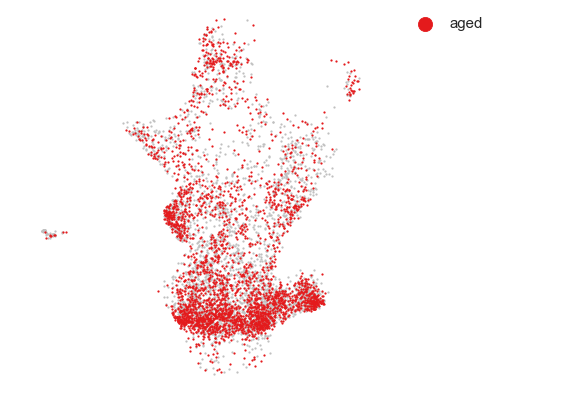

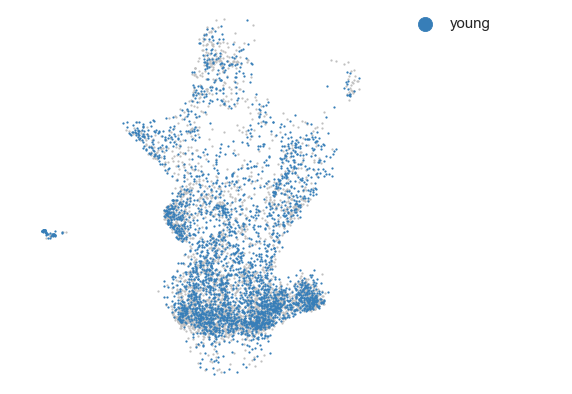

In [209]:
draw_scatter_groups_individual(Xs.obsm['X_umap_pca'], 
                    Xs.obs['age'],
                    cmap=cmap_age,
                    s=5, show_axes = False)

## Visualize metacells - percentage of young and aged cells

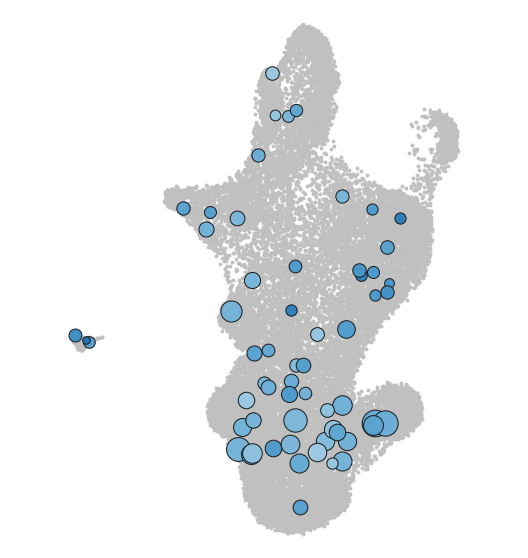

In [210]:
umap = pd.DataFrame(Xs_.obsm['X_umap_pca']).set_index(Xs_.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = mpl.colors.rgb2hex(plt.cm.Blues(Counter(Xs.obs['age'].loc[ass_tmp])['young'] / len(ass_tmp))))

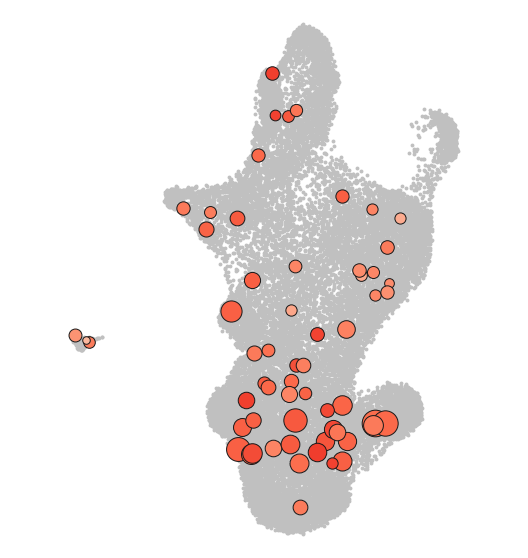

In [211]:
umap = pd.DataFrame(Xs_.obsm['X_umap_pca']).set_index(Xs_.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = mpl.colors.rgb2hex(plt.cm.Reds(Counter(Xs.obs['age'].loc[ass_tmp])['aged'] / len(ass_tmp))))

## Visualize metacells - ratio of young and aged cells

/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_82325/3891762367.py:62: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


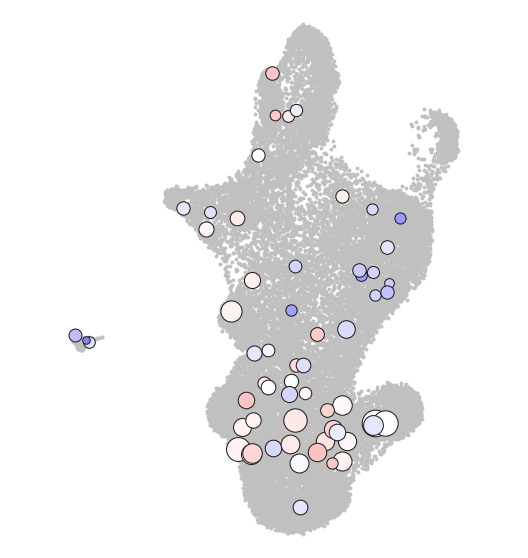

In [212]:
umap = pd.DataFrame(Xs_.obsm['X_umap_pca']).set_index(Xs_.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = mpl.colors.rgb2hex(plt.cm.bwr(Counter(Xs.obs['age'].loc[ass_tmp])['aged'] / len(ass_tmp))))
    
    
figname = 'umap_LUAD_mcs_age_12wk.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Most common cell population

In [213]:
cmap_epithelial_tumor = {'AT2-like': '#b2df8a',
                         'AT2': '#33a02c',
                         'High plasticity cell state': '#a50f15',
                         'AT1-like': '#fb6a4a',
                         'Ribosome high': '#c51b7d',
                         'Endoderm-like': '#542788',
                         'AT1': '#e6ab02',
                         'Ciliated':'#666666', 
                         'Other':'silver'}

/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_82325/2702581340.py:63: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


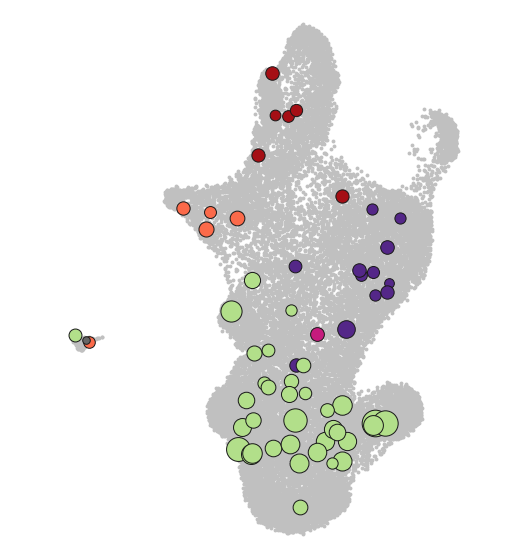

In [214]:
umap = pd.DataFrame(Xs_.obsm['X_umap_pca']).set_index(Xs_.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    cnts_tmp = Counter(Xs.obs['cl_epithelial_tumor_pca'].loc[ass_tmp])
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = cmap_epithelial_tumor[max(cnts_tmp, key=cnts_tmp.get)])
    
    
figname = 'umap_LUAD_mcs_pop_12wk.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Checkpoint

In [215]:
Xs.write_h5ad('%s/%s_Xs_LUAD_aging_KP_tumor_subsampled_metacells_12wk.h5' % (path_output, exp_id))

# Metacell representation of subsampled tumor data - 17-18wk

In [216]:
X = sc.read_h5ad('%s/%s_X_LUAD_aging_pp.h5' % (path_output, exp_id))

In [217]:
Xs = sc.read_h5ad('%s/%s_Xs_LUAD_aging_KP_tumor_subsampled.h5' % (path_output, exp_id))
Xs_ = sc.read_h5ad('%s/%s_Xs_LUAD_aging_KP_tumor_subsampled.h5' % (path_output, exp_id))

In [218]:
Xs.obsm['X_umap'] = Xs.obsm['X_umap_pca']

## Select healthy cells

In [219]:
c_sel = Xs.obs[Xs.obs['tumor_stage']=='17-18wk'].index

In [220]:
len(c_sel)

5120

In [221]:
Xs = Xs[c_sel]

## Use highly variable features which were used as input for UMAP + PC batch correction using harmony

In [222]:
sc.tl.pca(Xs, n_comps=50)

In [223]:
sc.external.pp.harmony_integrate(Xs, 'mouse', basis='X_pca', adjusted_basis='X_pca_harmony')

2022-08-12 14:30:58,567 - harmonypy - INFO - Iteration 1 of 10
2022-08-12 14:31:01,486 - harmonypy - INFO - Iteration 2 of 10
2022-08-12 14:31:03,979 - harmonypy - INFO - Iteration 3 of 10
2022-08-12 14:31:06,434 - harmonypy - INFO - Iteration 4 of 10
2022-08-12 14:31:08,221 - harmonypy - INFO - Iteration 5 of 10
2022-08-12 14:31:10,854 - harmonypy - INFO - Iteration 6 of 10
2022-08-12 14:31:12,488 - harmonypy - INFO - Converged after 6 iterations


In [224]:
model = SEACells.core.SEACells(Xs, 
                               build_kernel_on='X_pca_harmony', 
                               n_SEACells=51, 
                               n_waypoint_eigs=10,
                               waypt_proportion=0.9,
                               convergence_epsilon = 1e-5)

Building kernel...
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/5120 [00:00<?, ?it/s]

Making graph symmetric...
Computing RBF kernel...


  0%|          | 0/5120 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/5120 [00:00<?, ?it/s]

Constructing CSR matrix...


In [225]:
model.initialize_archetypes()

Building kernel on X_pca_harmony
Computing diffusion components from X_pca_harmony for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 40 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/21 [00:00<?, ?it/s]

Selecting 11 cells from greedy initialization.


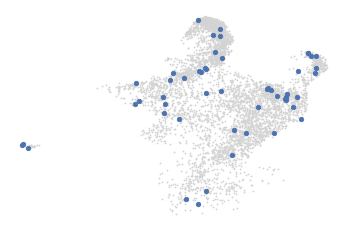

In [226]:
SEACells.plot.plot_initialization(Xs, model)

In [227]:
model.fit(n_iter=20)

Randomly initialized A matrix.
Setting convergence threshold at 0.01110918284640299
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 20 iterations.


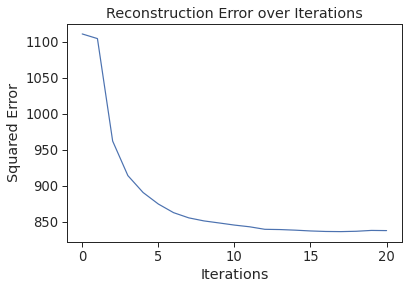

In [228]:
model.plot_convergence()

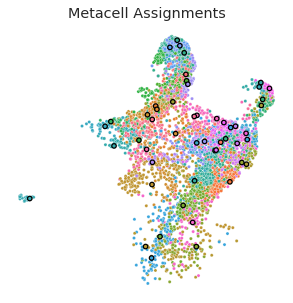

In [229]:
SEACells.plot.plot_2D(Xs, key='X_umap', colour_metacells=True)

/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


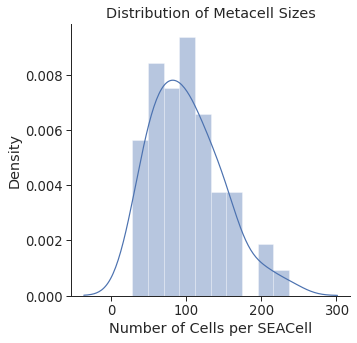

size
SEACell                  
AAAGGATAGTCTCGTA-12   160
AACAAAGCAAGACAAT-12    78
AACAAAGGTCGACTTA-12    54
ACCAAACGTAGGTACG-13   147
ACCTACCCATTGCCGG-12   172
ACGGTCGCATCACCAA-13    61
ACGTCCTAGGCCCAAA-13   109
ACGTCCTGTGGTCTTA-12   135
ACTTTGTCATCCGTGG-13    34
AGACTCAAGCGCCTAC-12   130
AGATCCAGTCATACCA-13   107
AGATCGTGTATGCGGA-12    57
AGCCAATAGCGAACTG-12   131
AGGGAGTCATCGGTTA-12    40
AGGGTGATCCGTCAAA-12   131
AGTCTCCCATAGAGGC-12   148
CAACGATCATGACAAA-13   120
CAGTTAGGTGCAATAA-13    91
CATACAGCAGCCTATA-13    65
CCTCATGTCAGGTGTT-13   102
CGACAGCCATACAGCT-12    57
GACTCTCCAGCACACC-12    89
GACTCTCGTTTCCCAC-12    70
GATTCTTGTACCTAAC-13   200
GCGAGAATCATGCTAG-13    44
GCGATCGGTGTTTCTT-13    84
GGAGGATCATCCAACA-12    63
GGGTTGCAGATGCGAC-11    35
GGTTAACCATGCCGGT-12    65
GTGGAGAGTTCTTGTT-12    35
GTTACCCTCTCGACGG-12    76
TAATCTCCAGGACAGT-13    95
TAATTCCGTGTCTTCC-12   118
TAGACTGTCTTCACGC-12    93
TATCTGTTCCTTCACG-12    70
TCAGCAATCATATGGC-12    83
TCAGGGCCATACCATG-13    28
TCATGAGCAGCTACTA-12   157
TCTTTGACAAAGCTAA-12    96
TGAGTCAAGGAACGAA-12   154
TGATTTCAGGCATCGA-13    56
TGCAGATCAAATGGAT-12   126
TGGTAGTTCTAGACAC-12    82
TGTTCCGAGCCTTGAT-10   106
TTACAGGTCAAGGACG-12   117
TTACGCCCATTCTCTA-12   237
TTACTGTCAAACACCT-13   202
TTCTTAGAGGTGCACA-11   107
TTGGATGCAGCATTGT-12    97
TTTACGTTCCCTGGTT-12    55
TTTAGTCCACTGGCCA-13   151

In [230]:
SEACells.plot.plot_SEACell_sizes(Xs, bins=10)

In [231]:
import seaborn as sns

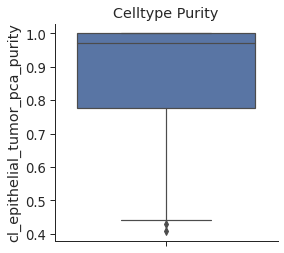

cl_epithelial_tumor_pca  \
SEACell                                           
AAAGGATAGTCTCGTA-12                    AT2-like   
AACAAAGCAAGACAAT-12               Endoderm-like   
AACAAAGGTCGACTTA-12               Endoderm-like   
ACCAAACGTAGGTACG-13                    AT1-like   
ACCTACCCATTGCCGG-12  High plasticity cell state   

                     cl_epithelial_tumor_pca_purity  
SEACell                                              
AAAGGATAGTCTCGTA-12                        0.812500  
AACAAAGCAAGACAAT-12                        1.000000  
AACAAAGGTCGACTTA-12                        0.888889  
ACCAAACGTAGGTACG-13                        0.408163  
ACCTACCCATTGCCGG-12                        1.000000

In [232]:
SEACell_purity = SEACells.evaluate.compute_celltype_purity(Xs, 'cl_epithelial_tumor_pca')

plt.figure(figsize=(4,4))
sns.boxplot(data=SEACell_purity, y='cl_epithelial_tumor_pca_purity')
plt.title('Celltype Purity')
sns.despine()
plt.show()
plt.close()

SEACell_purity.head()

# Visualize metacells

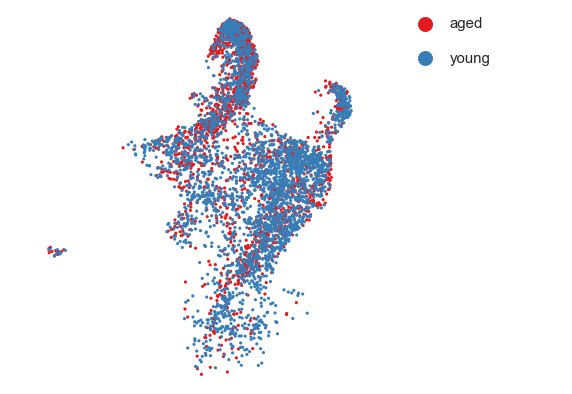

In [233]:
draw_scatter_groups(Xs.obsm['X_umap_pca'], 
                    Xs.obs['age'],
                    cmap_age,
                    s=10, show_axes = False)

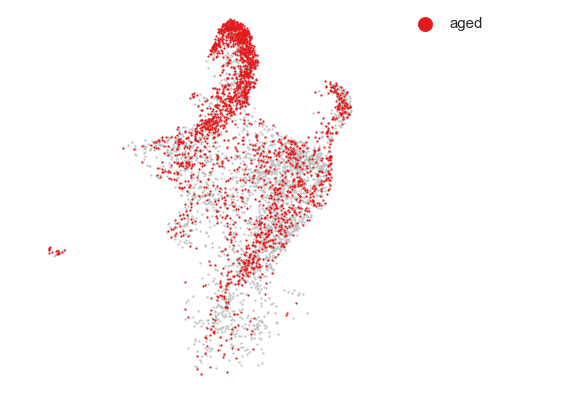

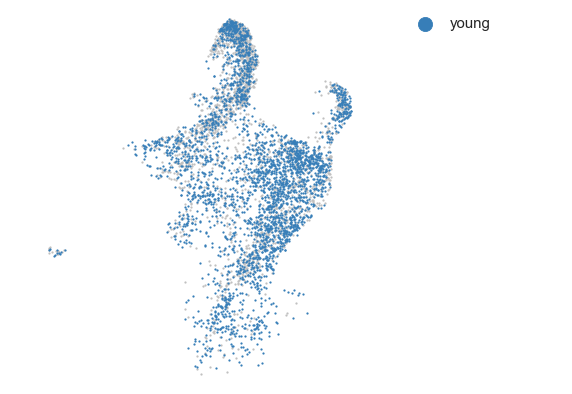

In [234]:
draw_scatter_groups_individual(Xs.obsm['X_umap_pca'], 
                    Xs.obs['age'],
                    cmap=cmap_age,
                    s=5, show_axes = False)

## Visualize metacells - percentage of young and aged cells

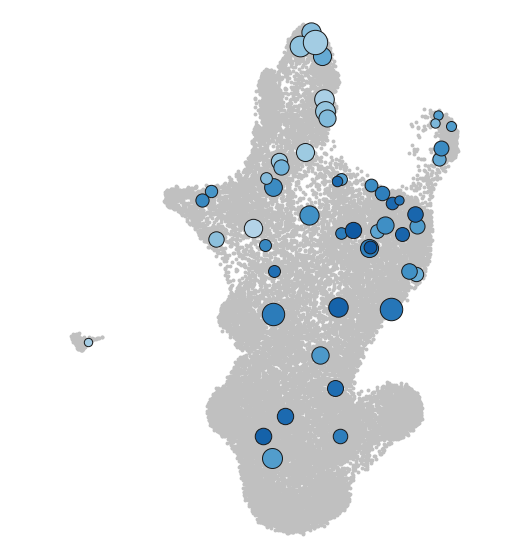

In [235]:
umap = pd.DataFrame(Xs_.obsm['X_umap_pca']).set_index(Xs_.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = mpl.colors.rgb2hex(plt.cm.Blues(Counter(Xs.obs['age'].loc[ass_tmp])['young'] / len(ass_tmp))))

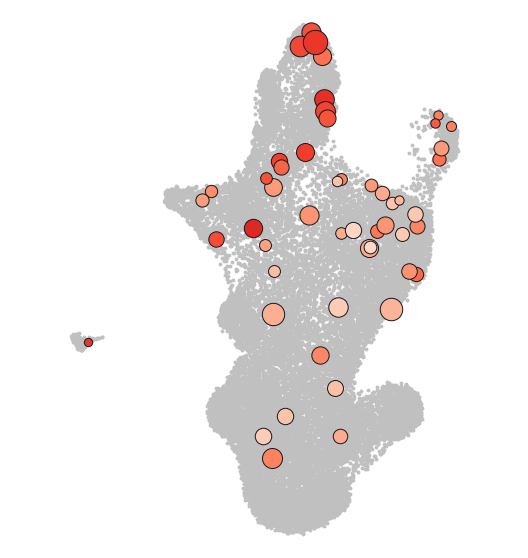

In [236]:
umap = pd.DataFrame(Xs_.obsm['X_umap_pca']).set_index(Xs_.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = mpl.colors.rgb2hex(plt.cm.Reds(Counter(Xs.obs['age'].loc[ass_tmp])['aged'] / len(ass_tmp))))

## Visualize metacells - ratio of young and aged cells

/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_82325/2770814106.py:62: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


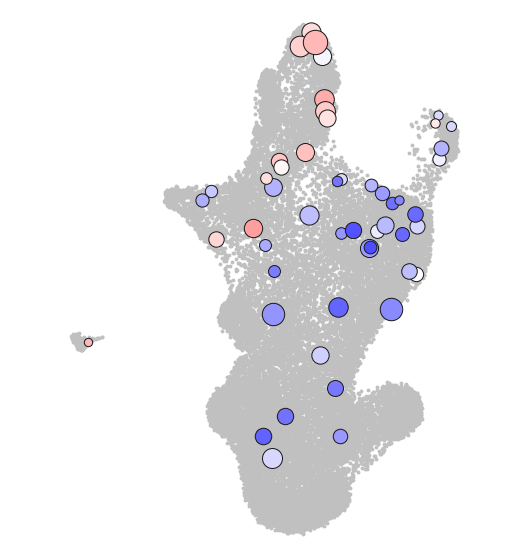

In [237]:
umap = pd.DataFrame(Xs_.obsm['X_umap_pca']).set_index(Xs_.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = mpl.colors.rgb2hex(plt.cm.bwr(Counter(Xs.obs['age'].loc[ass_tmp])['aged'] / len(ass_tmp))))
    
    
figname = 'umap_LUAD_mcs_age_1718wk.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Most common cell population

In [238]:
cmap_epithelial_tumor = {'AT2-like': '#b2df8a',
                         'AT2': '#33a02c',
                         'High plasticity cell state': '#a50f15',
                         'AT1-like': '#fb6a4a',
                         'Ribosome high': '#c51b7d',
                         'Endoderm-like': '#542788',
                         'AT1': '#e6ab02',
                         'Ciliated':'#666666', 
                         'Other':'silver'}

/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_82325/481929732.py:63: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


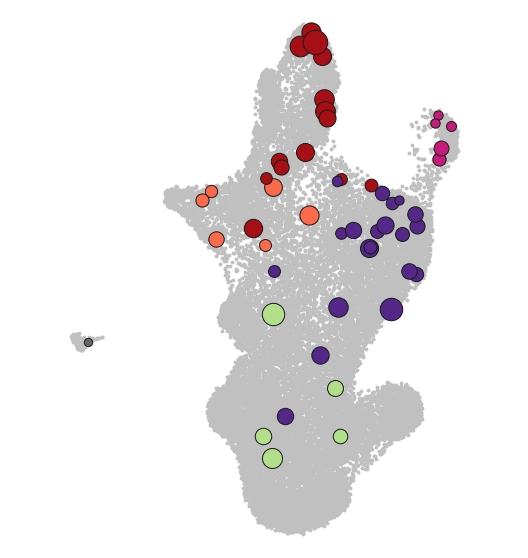

In [239]:
umap = pd.DataFrame(Xs_.obsm['X_umap_pca']).set_index(Xs_.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    cnts_tmp = Counter(Xs.obs['cl_epithelial_tumor_pca'].loc[ass_tmp])
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = cmap_epithelial_tumor[max(cnts_tmp, key=cnts_tmp.get)])
    
    
figname = 'umap_LUAD_mcs_pop_1718wk.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Checkpoint

In [240]:
Xs.write_h5ad('%s/%s_Xs_LUAD_aging_KP_tumor_subsampled_metacells_1718wk.h5' % (path_output, exp_id))

# Metacell representation of subsampled tumor data - 19-20wk

In [241]:
X = sc.read_h5ad('%s/%s_X_LUAD_aging_pp.h5' % (path_output, exp_id))

In [242]:
Xs = sc.read_h5ad('%s/%s_Xs_LUAD_aging_KP_tumor_subsampled.h5' % (path_output, exp_id))
Xs_ = sc.read_h5ad('%s/%s_Xs_LUAD_aging_KP_tumor_subsampled.h5' % (path_output, exp_id))

In [243]:
Xs.obsm['X_umap'] = Xs.obsm['X_umap_pca']

## Select healthy cells

In [244]:
c_sel = Xs.obs[Xs.obs['tumor_stage']=='19-20wk'].index

In [245]:
len(c_sel)

5850

In [246]:
Xs = Xs[c_sel]

## Use highly variable features which were used as input for UMAP + PC batch correction using harmony

In [247]:
sc.tl.pca(Xs, n_comps=50)

In [248]:
sc.external.pp.harmony_integrate(Xs, 'mouse', basis='X_pca', adjusted_basis='X_pca_harmony')

2022-08-12 14:43:04,139 - harmonypy - INFO - Iteration 1 of 10
2022-08-12 14:43:07,893 - harmonypy - INFO - Iteration 2 of 10
2022-08-12 14:43:11,152 - harmonypy - INFO - Iteration 3 of 10
2022-08-12 14:43:13,775 - harmonypy - INFO - Iteration 4 of 10
2022-08-12 14:43:15,354 - harmonypy - INFO - Iteration 5 of 10
2022-08-12 14:43:16,678 - harmonypy - INFO - Iteration 6 of 10
2022-08-12 14:43:18,305 - harmonypy - INFO - Iteration 7 of 10
2022-08-12 14:43:19,950 - harmonypy - INFO - Iteration 8 of 10
2022-08-12 14:43:21,388 - harmonypy - INFO - Iteration 9 of 10
2022-08-12 14:43:22,455 - harmonypy - INFO - Iteration 10 of 10
2022-08-12 14:43:24,384 - harmonypy - INFO - Stopped before convergence


In [249]:
model = SEACells.core.SEACells(Xs, 
                               build_kernel_on='X_pca_harmony', 
                               n_SEACells=58, 
                               n_waypoint_eigs=10,
                               waypt_proportion=0.9,
                               convergence_epsilon = 1e-5)

Building kernel...
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/5850 [00:00<?, ?it/s]

Making graph symmetric...
Computing RBF kernel...


  0%|          | 0/5850 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/5850 [00:00<?, ?it/s]

Constructing CSR matrix...


In [250]:
model.initialize_archetypes()

Building kernel on X_pca_harmony
Computing diffusion components from X_pca_harmony for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 45 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/23 [00:00<?, ?it/s]

Selecting 13 cells from greedy initialization.


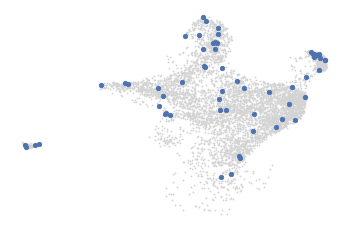

In [251]:
SEACells.plot.plot_initialization(Xs, model)

In [252]:
model.fit(n_iter=20)

Randomly initialized A matrix.
Setting convergence threshold at 0.011555108851114354
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 20 iterations.


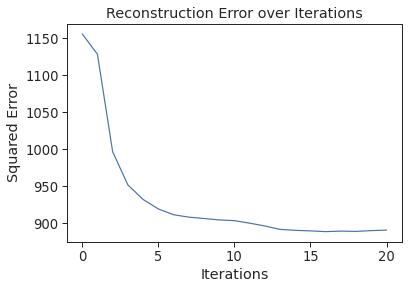

In [253]:
model.plot_convergence()

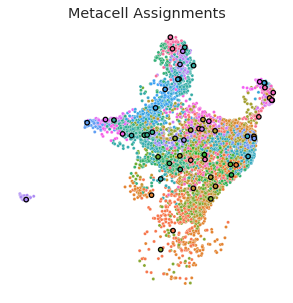

In [254]:
SEACells.plot.plot_2D(Xs, key='X_umap', colour_metacells=True)

/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


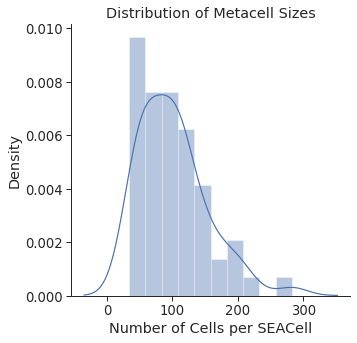

size
SEACell                  
AACAGGGTCGGATAAA-15   112
AACTTCTGTTACCCAA-14   121
AATCGACGTTTGTTCT-14   117
ACCCAAAGTAGCTTGT-14   107
ACCCAAATCGGTAACT-14   103
ACTCTCGAGGGAACAA-14   124
AGGCCACCAGGAAGTC-15    80
AGGGTCCCAGGCTACC-14    59
AGTACTGGTAGAGGAA-14   135
ATAGAGATCTTACACT-15   158
ATCCACCCAGGTGGAT-14    47
ATCGATGGTTCCGCGA-14   107
ATTCAGGCAACCCGCA-15    81
CACTAAGCATTGCAAC-14    44
CAGATACCAGCCGTCA-14   197
CAGGCCATCGCTCTAC-14   218
CATTTCAAGAAGCGCT-15    54
CCCTCTCGTCTTCCGT-14    69
CCGGACAGTAGGACTG-14    75
CCGGTGATCGTTAGAC-15   141
CCGTTCATCTCGCAGG-15    89
CCTATCGTCAGTGTGT-15    65
CCTTGTGAGTAAACAC-14    79
CGACAGCAGAAGCTGC-14   180
CGGAGAAGTTATTCCT-14   116
CTAACTTTCGTTAGAC-14    95
CTCCATGAGTGCAGCA-14   201
CTCCGATTCAAGTGTC-14   164
CTGCGAGCATTCGGGC-14    63
CTGCTCAAGCTAGAGC-14   110
CTTCTCTCAGGCACTC-15    97
GATAGCTAGTAGACAT-15    95
GCATCGGTCAAACCCA-15   100
GGCTTGGCATTCAGCA-14    46
GGGAAGTGTCGCACGT-14    42
GGGACAACAACTACGT-14   113
GGGAGATTCTTGGTGA-15    34
GGTAACTCAGCCTTCT-14   106
GTAACACCATTCGATG-14    62
GTCAGCGGTCTGATCA-14   145
GTCATTTCAGCATTGT-14   156
GTGAGGATCCTTATAC-14   143
GTGGGAATCATCGCAA-14   187
GTTACAGGTCTTCGAA-15    35
TCAGTTTGTCTAGTGT-15    52
TCATCCGCATGGCCCA-14    89
TCTAACTGTAGCGTCC-15    66
TCTACATAGGACTATA-14   121
TCTGCCACAATGTCAC-14    58
TCTGGCTCATGTTACG-14    42
TGCAGGCTCAGTCCGG-15    34
TGTGATGCACTATGTG-15    36
TGTTGAGTCTACTGAG-15    55
TGTTGGACACTGTTCC-14    90
TTACTGTGTATGATCC-14   117
TTCATGTGTCTACAAC-14   283
TTGTTCACACAACCGC-15    54
TTTACGTTCGAATGCT-15    81

In [255]:
SEACells.plot.plot_SEACell_sizes(Xs, bins=10)

In [256]:
import seaborn as sns

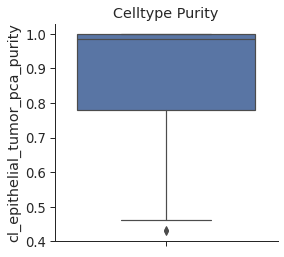

cl_epithelial_tumor_pca  \
SEACell                                           
AACAGGGTCGGATAAA-15                    AT1-like   
AACTTCTGTTACCCAA-14                    AT1-like   
AATCGACGTTTGTTCT-14               Endoderm-like   
ACCCAAAGTAGCTTGT-14  High plasticity cell state   
ACCCAAATCGGTAACT-14  High plasticity cell state   

                     cl_epithelial_tumor_pca_purity  
SEACell                                              
AACAGGGTCGGATAAA-15                        1.000000  
AACTTCTGTTACCCAA-14                        0.983471  
AATCGACGTTTGTTCT-14                        0.965812  
ACCCAAAGTAGCTTGT-14                        1.000000  
ACCCAAATCGGTAACT-14                        0.902913

In [257]:
SEACell_purity = SEACells.evaluate.compute_celltype_purity(Xs, 'cl_epithelial_tumor_pca')

plt.figure(figsize=(4,4))
sns.boxplot(data=SEACell_purity, y='cl_epithelial_tumor_pca_purity')
plt.title('Celltype Purity')
sns.despine()
plt.show()
plt.close()

SEACell_purity.head()

# Visualize metacells

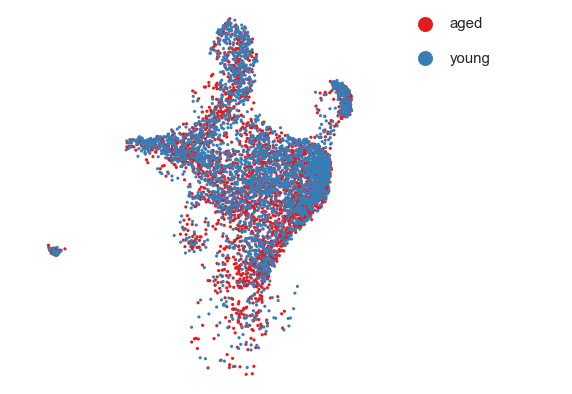

In [258]:
draw_scatter_groups(Xs.obsm['X_umap_pca'], 
                    Xs.obs['age'],
                    cmap_age,
                    s=10, show_axes = False)

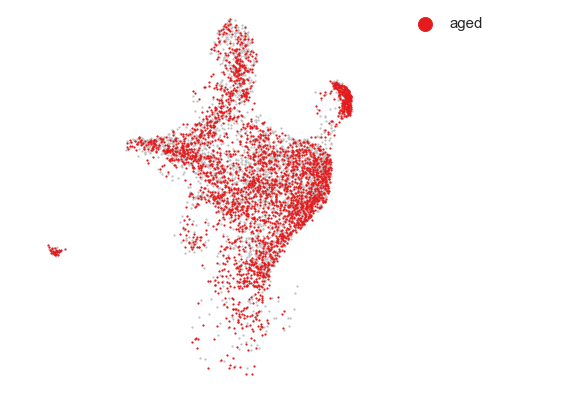

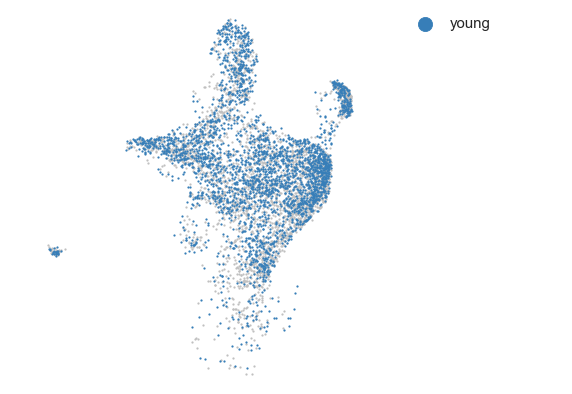

In [259]:
draw_scatter_groups_individual(Xs.obsm['X_umap_pca'], 
                    Xs.obs['age'],
                    cmap=cmap_age,
                    s=5, show_axes = False)

## Visualize metacells - percentage of young and aged cells

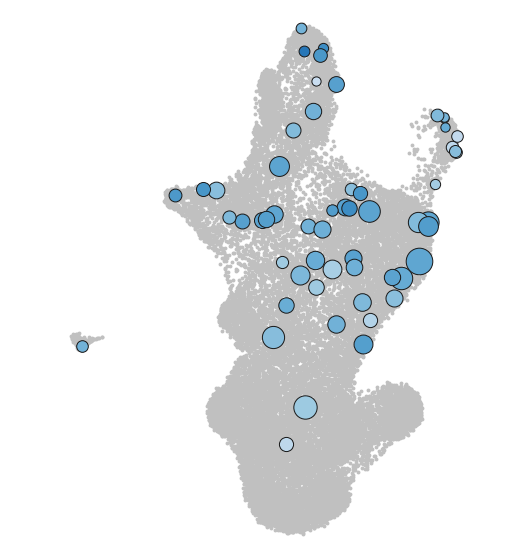

In [260]:
umap = pd.DataFrame(Xs_.obsm['X_umap_pca']).set_index(Xs_.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = mpl.colors.rgb2hex(plt.cm.Blues(Counter(Xs.obs['age'].loc[ass_tmp])['young'] / len(ass_tmp))))

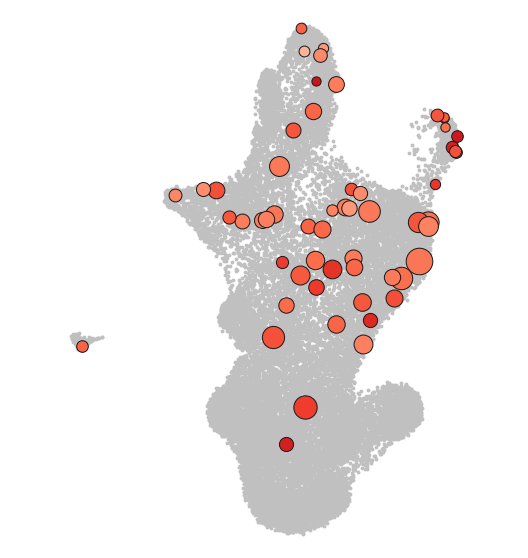

In [261]:
umap = pd.DataFrame(Xs_.obsm['X_umap_pca']).set_index(Xs_.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = mpl.colors.rgb2hex(plt.cm.Reds(Counter(Xs.obs['age'].loc[ass_tmp])['aged'] / len(ass_tmp))))

## Visualize metacells - ratio of young and aged cells

/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_82325/3430364302.py:62: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


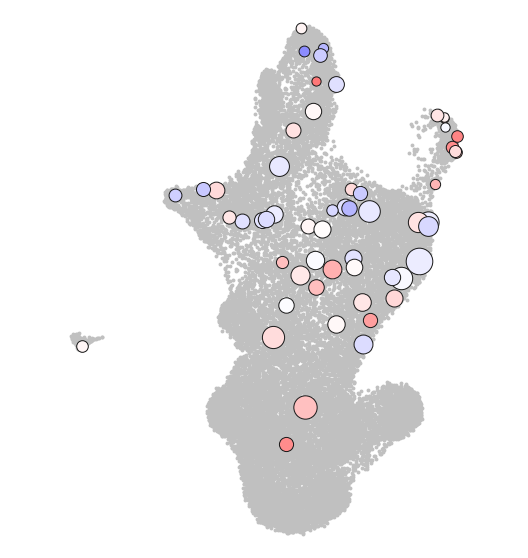

In [266]:
umap = pd.DataFrame(Xs_.obsm['X_umap_pca']).set_index(Xs_.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = mpl.colors.rgb2hex(plt.cm.bwr(Counter(Xs.obs['age'].loc[ass_tmp])['aged'] / len(ass_tmp))))
    
    
figname = 'umap_LUAD_mcs_age_1920wk.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Most common cell population

In [263]:
cmap_epithelial_tumor = {'AT2-like': '#b2df8a',
                         'AT2': '#33a02c',
                         'High plasticity cell state': '#a50f15',
                         'AT1-like': '#fb6a4a',
                         'Ribosome high': '#c51b7d',
                         'Endoderm-like': '#542788',
                         'AT1': '#e6ab02',
                         'Ciliated':'#666666', 
                         'Other':'silver'}

/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_82325/13528370.py:63: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


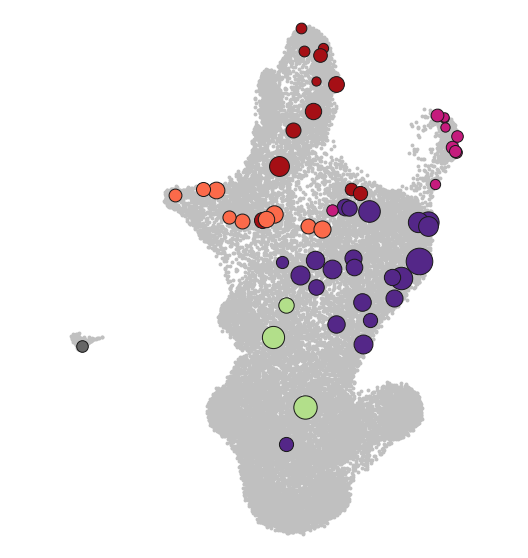

In [264]:
umap = pd.DataFrame(Xs_.obsm['X_umap_pca']).set_index(Xs_.obs_names).join(Xs.obs['SEACell'])
mcs = umap.loc[Xs.obs['SEACell'].unique()]
mc_dict = {mc:Xs.obs[Xs.obs['SEACell']==mc].index for mc in mcs.index}
s = 15
mcf = 2.5

#initialize figure
    
height = 10
width = 10
plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

#define x- and y-limits

x_min, x_max = np.min(umap[0]), np.max(umap[0])
y_min, y_max = np.min(umap[1]), np.max(umap[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

#define x- and y-axes

ax = plt.subplot(gs[0])

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

clean_axis(ax)

#plot single cells

ax.scatter(umap[0],
           umap[1], 
           s = s,
           linewidth = 0.0,
           c = 'silver')

#plot metacells


for mc in mcs.index:
    ass_tmp = mc_dict[mc]
    cnts_tmp = Counter(Xs.obs['cl_epithelial_tumor_pca'].loc[ass_tmp])
    ax.scatter(mcs.loc[mc,0],
               mcs.loc[mc,1], 
               s = len(ass_tmp) * mcf,
               linewidth = 1.0,
               edgecolor='k',
               c = cmap_epithelial_tumor[max(cnts_tmp, key=cnts_tmp.get)])
    
    
figname = 'umap_LUAD_mcs_pop_1920wk.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Checkpoint

In [265]:
Xs.write_h5ad('%s/%s_Xs_LUAD_aging_KP_tumor_subsampled_metacells_1920wk.h5' % (path_output, exp_id))